In [1]:
import numpy as np
import sys
import os
import re
import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
import netCDF4

from run_realization_v2 import setup_submit_wait
from DA_operators import operator_clm_SMAP, operator_clm_FLX

from settings import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap

# from multiprocessing import Pool
import multiprocessing as mp

from itertools import repeat
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

from helpers import haversine_distance

sys.path.append('/p/project/cjibg36/jibg3674/eCLM_PyDA/TSMP_DA/DA')
folder_results = '/p/scratch/cjibg36/jibg3674/CLM5_DA'
if folder_results not in sys.path:
    sys.path.insert(0,os.path.join(folder_results,'settings'))


In [67]:
settings_DA

{'param_setup': [<function setup_parameters.setup_orgmax_v2(settings_setup, settings_run)>,
  <function setup_parameters.setup_fff(settings_setup, settings_run)>,
  <function setup_parameters.setup_h2o_canopy_max(settings_setup, settings_run)>,
  <function setup_parameters.setup_mineral_hydraulic(settings_setup, settings_run)>,
  <function setup_parameters.setup_om_hydraulic(settings_setup, settings_run)>,
  <function setup_parameters.setup_kmax_v2(settings_setup, settings_run)>,
  <function setup_parameters.setup_medlyn_slope_v2(settings_setup, settings_run)>,
  <function setup_parameters.setup_medlyn_intercept_v2(settings_setup, settings_run)>,
  <function setup_parameters.setup_luna(settings_setup, settings_run)>,
  <function setup_parameters.setup_sandfrac_anom(settings_gen, settings_run)>,
  <function setup_parameters.setup_clayfrac_anom(settings_gen, settings_run)>,
  <function setup_parameters.setup_orgfrac_anom(settings_gen, settings_run)>],
 'param_gen': [<function generate_pa

In [54]:
def get_TSMP_grid(file_centre,file_corner,ignore_rivers=False):
    grid_centre = xr.open_dataset(file_centre, decode_times=False)
    grid_corner = xr.open_dataset(file_corner)

    lon_edges = np.concatenate((grid_corner.lon.values[:,-1],grid_corner.lon.values[:,0],grid_corner.lon.values[0,:],grid_corner.lon.values[-1,:]))
    lat_edges = np.concatenate((grid_corner.lat.values[:,-1],grid_corner.lat.values[:,0],grid_corner.lat.values[0,:],grid_corner.lat.values[-1,:]))
    lsm_edges = np.zeros(lat_edges.shape)
    
    grid_TSMP = xr.Dataset(data_vars=dict(lon_centre=(['x','y'], grid_centre.lon.values),
                                          lat_centre=(['x','y'], grid_centre.lat.values),
                                          lon_corner=(['xc','yc'], grid_corner.lon.values),
                                          lat_corner=(['xc','yc'], grid_corner.lat.values),
                                          lsm=(['x','y'], grid_centre.LLSM[0].values),
                                          lon_edges=(['ne'], lon_edges),
                                          lat_edges=(['ne'], lat_edges),
                                          lsm_edges=(['ne'], lsm_edges)))
    
    
    if ignore_rivers:
        # in the land-sea mask, set rivers to a value of 3, in which case they are ignored later in the interpolation process
        grid_TSMP['lsm'] = grid_TSMP['lsm'].where((grid_centre.mask_rivers.values==0),3)

    return grid_TSMP

def interpolate_model_results(i_real,settings_run, indices_z=[0,1],var='H2OSOI',history_stream='h0'):

        files_clm = sorted(glob(os.path.join(settings_run['dir_iter'],'R%3.3i/**/*.clm2.%s.*.nc'%(i_real,history_stream) )))
        # print(files_clm)
            
        data_TSMP = xr.open_dataset(files_clm[1])
        # add curvilinear lon/lat 
        data_TSMP = data_TSMP.assign_coords(lon_c=(('lat','lon'), get_TSMP_grid(file_lsm,file_corner,ignore_rivers=False).lon_centre.values))
        data_TSMP = data_TSMP.assign_coords(lat_c=(('lat','lon'), get_TSMP_grid(file_lsm,file_corner,ignore_rivers=False).lat_centre.values))

        if var == 'H2OSOI':
            SM = data_TSMP.H2OSOI[0]
        elif var == 'SOILLIQ': #base moisture on liquid part only
            eCLM_dz = np.array([0.02,0.04,0.06,0.08,0.120,
                                0.160,0.200,0.240,0.280,0.320,
                                0.360,0.400,0.440,0.540,0.640,
                                0.740,0.840,0.940,1.040,1.140,
                                2.390,4.676,7.635,11.140,15.115])
            SM = data_TSMP.SOILLIQ[0]/(eCLM_dz[0:20,np.newaxis,np.newaxis]*1000)
        else:
            raise RuntimeError('For soil moisture only H2OSOI and SOILLIQ supported')


        if indices_z is None:
            data_TSMP_sm = SM[0].values
        elif type(indices_z) == int:
            data_TSMP_sm = SM[indices_z].values
        elif type(indices_z) == list:
            indices_select = np.ix_(np.array(indices_z),
                                    np.arange(SM.values.shape[1]),
                                    np.arange(SM.values.shape[2]))
            data_TSMP_sm = SM.values[indices_select].mean(axis=0)
        else:
            raise RuntimeError('indices_z should be None, int, or list of ints')
                
        mask_nan = ~np.isnan(data_TSMP_sm)
        print(np.count_nonzero(mask_nan == 1))
        print(data_TSMP_sm.shape)
        
        return data_TSMP_sm, mask_nan, data_TSMP.lon_c.values, data_TSMP.lat_c.values
    
         # self.data_TSMP_i[date_] = griddata((data_TSMP.lon_c.values[mask_nan],data_TSMP.lat_c.values[mask_nan]),data_TSMP_sm[mask_nan],(self.lons_out[date_],self.lats_out[date_]), method='nearest')


In [58]:
import importlib
import functions  
importlib.reload(functions)

settings_run['dir_iter'] = '/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap_16ens_bck/20190501-20190730/i000'
file_lsm = settings_DA['file_lsm']
file_corner = settings_DA['file_corner']

n_lat = 432
n_lon = 444
n_data = 102982
n_ensemble = 16
data_m = [np.zeros((n_lat,n_lon)) for _ in range(n_ensemble)]

for i_real in np.arange(1,n_ensemble+1):   
    print('%i/%i' % (i_real,n_ensemble), flush=True)
    data_m[i_real-1], mask_nan, lons, lats =  interpolate_model_results(i_real,settings_run)

data_f = [member[mask_nan] for member in data_m]
data_f = np.transpose(np.array(data_f))
print(data_f.shape)

1/16
102982
(432, 444)
2/16
102982
(432, 444)
3/16
102982
(432, 444)
4/16
102982
(432, 444)
5/16
102982
(432, 444)
6/16
102982
(432, 444)
7/16
102982
(432, 444)
8/16
102982
(432, 444)
9/16
102982
(432, 444)
10/16
102982
(432, 444)
11/16
102982
(432, 444)
12/16
102982
(432, 444)
13/16
102982
(432, 444)
14/16
102982
(432, 444)
15/16
102982
(432, 444)
16/16
102982
(432, 444)
(102982, 16)


In [2]:
import multiprocessing as mp
mp.cpu_count()

80

In [238]:
Dobs_mat.shape

(28370, 3)

In [18]:
print(data_a.max(),data_a.min())
print(data_f.max(),data_f.min())
print(np.nanstd(data_a,axis=1).max(),np.nanstd(data_a,axis=1).min())
print(np.nanstd(data_f,axis=1).max(),np.nanstd(data_f,axis=1).min())

1.0236849775025232 -0.011331365343268984
0.99443096 0.000375
0.21245430881537178 0.0007246353548023861
0.20308106 0.00069192343


/tmp/ipykernel_16658/47792904.py:22: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data_2d, axis=0)


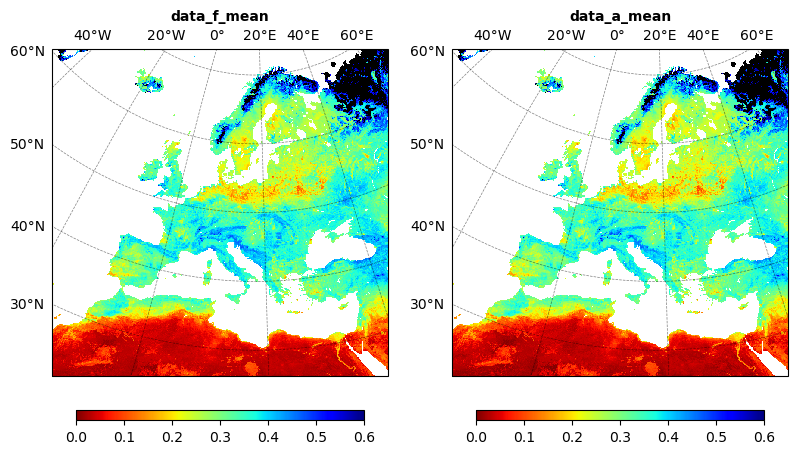

In [62]:
def reshape_and_average(data, mask_nan, n_lat, n_lon, n_ensemble):
    """
    Reshape flattened ensemble data back to 2D and calculate the ensemble mean.

    Parameters:
    - data_f: Pandas DataFrame containing flattened ensemble data.
    - mask_nan: Boolean mask indicating the non-NaN positions.
    - n_lat: Number of latitude points.
    - n_lon: Number of longitude points.
    - n_ensemble: Number of ensemble members.

    Returns:
    - data_f_mean: 2D array of ensemble-averaged data with shape (n_lat, n_lon).
    """
    data_2d = []

    for i in range(n_ensemble):
        full_array = np.full((n_lat, n_lon), np.nan)
        full_array[mask_nan] = data[:, i]
        data_2d.append(full_array)
    data_2d = np.array(data_2d)
    data_mean = np.nanmean(data_2d, axis=0)  
    return data_mean

data_f_mean = reshape_and_average(data_f, mask_nan, n_lat=432, n_lon=444, n_ensemble=3)
data_a_mean = reshape_and_average(data_a, mask_nan, n_lat=432, n_lon=444, n_ensemble=3)

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import pandas as pd 
from datetime import datetime
%matplotlib inline
proj = ccrs.RotatedPole(pole_longitude=-162.0, pole_latitude=39.25, central_rotated_longitude=0, globe=None)
    
fig = plt.figure(figsize=(8,5))

ax1 = fig.add_axes([0.03, 0.07, 0.42, 0.95],projection=proj)
ax2 = fig.add_axes([0.53, 0.07, 0.42, 0.95],projection=proj)
cax1 = fig.add_axes([0.06, 0.13, 0.36, 0.02])
cax2 = fig.add_axes([0.56, 0.13, 0.36, 0.02])

cmap = plt.get_cmap('jet_r').copy()
cmap.set_extremes(under='r', over='k')

cmesh1 = ax1.pcolormesh(lons,lats,data_f_mean,
                        cmap=cmap,vmin=0.,vmax=.6,transform=ccrs.PlateCarree())
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', y_inline=False,x_inline=False,draw_labels=True)
gl1.right_labels=False
gl1.bottom_labels = False
ax1.set_title('data_f_mean',weight="bold",fontsize=10)
cbar1 = plt.colorbar(cmesh1, cax=cax1, orientation='horizontal')

cmesh2 = ax2.pcolormesh(lons,lats,data_a_mean,
                        cmap=cmap,vmin=0.,vmax=.6,transform=ccrs.PlateCarree())
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', y_inline=False,x_inline=False,draw_labels=True)
gl2.right_labels=False
gl2.bottom_labels = False
ax2.set_title('data_a_mean',weight="bold",fontsize=10)
cbar2 = plt.colorbar(cmesh2, cax=cax2, orientation='horizontal')


In [20]:
from scipy.interpolate import griddata
lat_min = lats.min().item()
lat_max = lats.max().item()
lon_min = lons.min().item()
lon_max = lons.max().item()

file_name = '/p/scratch/cjibg36/jibg3674/SMAP_EURO/NSIDC0772_LatLon_EASE2_M09km_v1.0.nc'
nc_file = netCDF4.Dataset(file_name, 'r')
lon_ease   = nc_file.variables['longitude'][:]
lat_ease   = nc_file.variables['latitude'][:]

lat_mask = (lat_ease >= lat_min) & (lat_ease <= lat_max)
lon_mask = (lon_ease >= lon_min) & (lon_ease <= lon_max)
latlon_mask = lat_mask & lon_mask
lat_indices = np.where((lat_ease[:, 0] >= lat_min) & (lat_ease[:, 0] <= lat_max))[0]
lon_indices = np.where((lon_ease[0, :] >= lon_min) & (lon_ease[0, :] <= lon_max))[0]
lat_subset_2d = lat_ease[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
lon_subset_2d = lon_ease[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

nc_file.close()

ease_points = np.array([lat_subset_2d.flatten(), lon_subset_2d.flatten()]).T
smap_points = a.values.flatten()

grid_points = np.array([lats.flatten(), lons.flatten()]).T
sm_interp = griddata(ease_points, smap_points, grid_points, method='nearest')
sm_interp = sm_interp.reshape(lats.shape)


In [51]:
print(np.nanmax(data_a_mean-data_f_mean),np.nanmin(data_a_mean-data_f_mean))
print(np.nanmax((data_f_mean-sm_interp)-(data_f_mean-sm_interp)))
print(np.nanmin((data_f_mean-sm_interp)-(data_f_mean-sm_interp)))
print(np.nanmax((data_f_mean-sm_interp)))
print(np.nanmin((data_f_mean-sm_interp)))

0.8648590686611963 -0.4355839701959841
0.0
0.0
0.4672364473342895
-0.20251977245012914


In [50]:
sm_interp

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

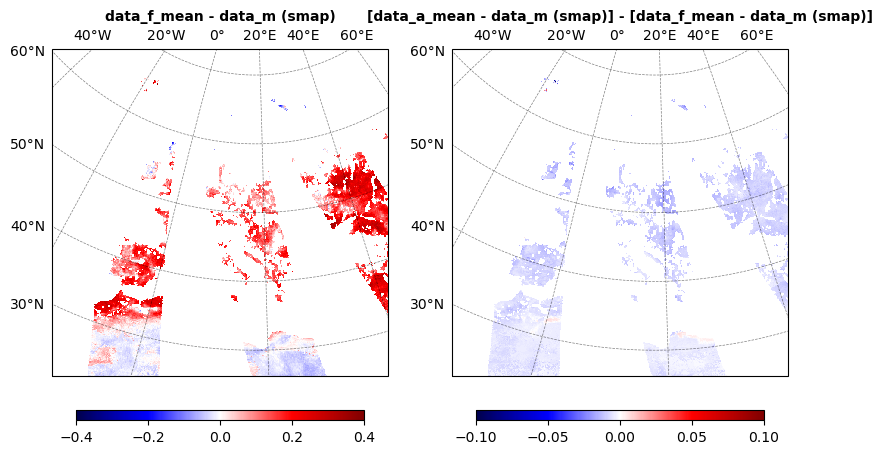

In [60]:
fig = plt.figure(figsize=(8,5))

ax1 = fig.add_axes([0.03, 0.07, 0.42, 0.95],projection=proj)
ax2 = fig.add_axes([0.53, 0.07, 0.42, 0.95],projection=proj)
cax1 = fig.add_axes([0.06, 0.13, 0.36, 0.02])
cax2 = fig.add_axes([0.56, 0.13, 0.36, 0.02])

cmap = plt.get_cmap('seismic').copy()
cmap.set_extremes(under='k', over='r')

cmesh1 = ax1.pcolormesh(lons,lats,data_f_mean-sm_interp,
                        cmap=cmap,vmin=-.4,vmax=.4,transform=ccrs.PlateCarree())
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', y_inline=False,x_inline=False,draw_labels=True)
gl1.right_labels=False
gl1.bottom_labels = False
ax1.set_title('data_f_mean - data_m (smap)',weight="bold",fontsize=10)
cbar1 = plt.colorbar(cmesh1, cax=cax1, orientation='horizontal')

cmesh2 = ax2.pcolormesh(lons,lats,(data_a_mean-sm_interp)-(data_f_mean-sm_interp),
                        cmap=cmap,vmin=-.1,vmax=.1,transform=ccrs.PlateCarree())
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', y_inline=False,x_inline=False,draw_labels=True)
gl2.right_labels=False
gl2.bottom_labels = False
ax2.set_title('[data_a_mean - data_m (smap)] - [data_f_mean - data_m (smap)]',weight="bold",fontsize=10)
cbar2 = plt.colorbar(cmesh2, cax=cax2, orientation='horizontal')

In [4]:
def parse_datetime_smap(files):
    dates = []
    for file_ in files:
        date_ = pd.to_datetime(os.path.basename(file_).split('P_E_')[1].split('_')[0]) + timedelta(hours=12)
        dates.append(date_)
    return dates

def read_SMAP(file_):
    ncf = netCDF4.Dataset(file_)
    group_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')
    group_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')

    data_pm = xr.open_dataset(xr.backends.NetCDF4DataStore(group_pm))
    data_am = xr.open_dataset(xr.backends.NetCDF4DataStore(group_am))

    return data_am, data_pm

def unpackbits(x, num_bits):
    #function that converts int into series of bits (used for 0/1 in SMAP quality flags)
    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")
    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])
    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])

def get_measurements(folder_SMAP, lats, lons, date_results_iter, 
                     mode='pm',qual_level=1,max_deviation_time=timedelta(days=1)):

    for date_ in [date_results_iter]:
        files_SMAP = sorted(glob(os.path.join(folder_SMAP,'nc_%4.4i/*.nc'%date_.year)))
        dates_SMAP = parse_datetime_smap(files_SMAP)
        i_closest = np.argmin(np.abs(pd.to_datetime(dates_SMAP) - date_))
        diff_days = abs(dates_SMAP[i_closest] - date_)
        if diff_days > max_deviation_time:
            print('Measurement and model output differ more than a day, SMAP: %s, TSMP: %s'%(dates_SMAP[i_closest],date_))
            # This happens e.g. when not every day has a measurement
        else:
            file_SMAP = files_SMAP[i_closest]
            data_SMAP_am, data_SMAP_pm = read_SMAP(file_SMAP)
            print(date_,file_SMAP)
            
            lat_min = lats.min().item()
            lat_max = lats.max().item()
            lon_min = lons.min().item()
            lon_max = lons.max().item()
            print(f"Latitude bounds: min = {lat_min}, max = {lat_max}")
            print(f"Longitude bounds: min = {lon_min}, max = {lon_max}")
            if mode == 'am':
                # select valid datapoints where the soil moisture and location are given
                mask_data_valid = ~np.isnan(data_SMAP_am.soil_moisture) & ~np.isnan(data_SMAP_am.longitude) 
                if qual_level > 0: #quality level; when 0 use all retrievals, with 1 only use recommended retrievals
                    qual_flags = unpackbits(data_SMAP_am.retrieval_qual_flag.values.astype(int),4)
                    mask_data_valid = mask_data_valid & (qual_flags[:,:,0]==0)
                # Select valid points: valid data, and within the given TSMP domain
                sm = data_SMAP_am.soil_moisture.where(mask_data_valid).values[mask_data_valid]
                lons = data_SMAP_am.longitude.where(mask_data_valid).values[mask_data_valid]
                lats = data_SMAP_am.latitude.where(mask_data_valid).values[mask_data_valid]
                
            elif mode == 'pm':
                # print(data_SMAP_pm.dims)
                # print(data_SMAP_pm.coords)
                # create a mask for the valid lat/lon range
                lat_mask = (data_SMAP_pm['latitude_pm'] >= lat_min) & (data_SMAP_pm['latitude_pm'] <= lat_max)
                lon_mask = (data_SMAP_pm['longitude_pm'] >= lon_min) & (data_SMAP_pm['longitude_pm'] <= lon_max)
                latlon_mask = lat_mask & lon_mask
                mask_data_in = data_SMAP_pm.where(latlon_mask, drop=True)
 
                if qual_level == 1: #quality level; when 0 use all retrievals, with 1 only use recommended retrievals
                    qual_flags = unpackbits(mask_data_in.retrieval_qual_flag_pm.values.astype(int),4)
                    # print(qual_flags.shape) # (497, 1246, 4)
                    mask_data_valid = mask_data_in.soil_moisture_pm.where(qual_flags[:,:,0]==0, drop=False)
                    # print(mask_data_valid.shape) # (497, 1246)
                    
                
#                 sm = data_SMAP_pm.soil_moisture_pm.where(mask_data_in).values[mask_data_valid]
#                 print(sm.shape)
                
#                 lons = data_SMAP_pm.longitude_pm.where(mask_data_in).values[mask_data_valid]
#                 lats = data_SMAP_pm.latitude_pm.where(mask_data_in).values[mask_data_valid]
#                 print(f"data_SMAP_pm.soil_moisture_pm [{date_}] is: {data_SMAP_pm.soil_moisture_pm.shape}")
#                 print(f"The shape of sm[{date_}] is: {sm.shape}")

            else:
                raise RuntimeError('mode should be am or pm')

            return(mask_data_valid)
            # poor man's check that measurement points are on land and lie within the TSMP domain... There might be a better solution for this (convex hull check on EU-11 polygon?) 
#             mask_SMAP_lsm = griddata((np.concatenate((self.grid_TSMP.lon_centre.values.ravel(),self.grid_TSMP.lon_edges)),np.concatenate((self.grid_TSMP.lat_centre.values.ravel(),self.grid_TSMP.lat_edges))),
#                                      np.concatenate((self.grid_TSMP.lsm.values.ravel(),self.grid_TSMP.lsm_edges)),
#                                      (lons,lats),method='nearest') == 2

#             self.lons_out[date_] = lons[mask_SMAP_lsm]
#             self.lats_out[date_] = lats[mask_SMAP_lsm]
#             self.sm_out[date_] = sm[mask_SMAP_lsm]
#             print(f"The shape of sm_out[{date_}] is: {self.sm_out[date_].shape}")
#             array_dates = np.append(array_dates, np.array([date_ for i in range(mask_SMAP_lsm.sum())]))        

In [5]:
i_date = 0
date_results_iter = date_results_binned[i_date].copy()
date_start_sim = date_results_binned[i_date][0][0]#datetime(2019,1,2,12,0,0)
date_end_sim = date_results_binned[i_date][-1][-1]#datetime(2019,12,31,12,0,0)

# add spinup if necessary:
if settings_run['ndays_spinup'] is not None:
    date_results_iter.insert(0,list(date_range_noleap(date_start_sim-timedelta(days=settings_run['ndays_spinup']),date_start_sim,periods=2)))


In [6]:
folder_SMAP = settings_DA['folder_SMAP']
a = get_measurements(folder_SMAP, lats, lons, date_results_iter[1][0])

from scipy.interpolate import griddata
lat_min = lats.min().item()
lat_max = lats.max().item()
lon_min = lons.min().item()
lon_max = lons.max().item()

file_name = '/p/scratch/cjibg36/jibg3674/SMAP_EURO/NSIDC0772_LatLon_EASE2_M09km_v1.0.nc'
nc_file = netCDF4.Dataset(file_name, 'r')
lon_ease   = nc_file.variables['longitude'][:]
lat_ease   = nc_file.variables['latitude'][:]

lat_mask = (lat_ease >= lat_min) & (lat_ease <= lat_max)
lon_mask = (lon_ease >= lon_min) & (lon_ease <= lon_max)
latlon_mask = lat_mask & lon_mask
lat_indices = np.where((lat_ease[:, 0] >= lat_min) & (lat_ease[:, 0] <= lat_max))[0]
lon_indices = np.where((lon_ease[0, :] >= lon_min) & (lon_ease[0, :] <= lon_max))[0]
lat_subset_2d = lat_ease[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
lon_subset_2d = lon_ease[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

nc_file.close()

ease_points = np.array([lat_subset_2d.flatten(), lon_subset_2d.flatten()]).T
smap_points = a.values.flatten()

grid_points = np.array([lats.flatten(), lons.flatten()]).T
sm_interp = griddata(ease_points, smap_points, grid_points, method='nearest')
sm_interp = sm_interp.reshape(lats.shape)

sm_interp_1d = sm_interp.flatten()
dataset2 = data_m[0].flatten()
mask_nan_1d = mask_nan.flatten()

sm_interp_masked = sm_interp_1d[mask_nan_1d == 1]
mask_nonan = ~np.isnan(sm_interp_masked)
sm_interp_masked_nonan = sm_interp_masked[mask_nonan]

#indices = np.where(~np.isnan(sm_interp_masked))[0]
indices = mask_nonan.astype(int)

2019-05-01 20:00:00 /p/project/cjibg36/jibg3674/shared_DA/SMAP/nc_2019/SMAP_L3_SM_P_E_20190501_R18290_001_HEGOUT.nc
Latitude bounds: min = 20.57646369934082, max = 73.68499755859375
Longitude bounds: min = -47.60581588745117, max = 68.72893524169922


In [17]:

n_obs  = sm_interp_masked_nonan.shape[0]
obs_index = np.where(indices == 1)[0]
obs_stdev = 0.04
obs_var = obs_stdev * obs_stdev

data_a, K_gain, A_mat_a, Dobs_mat, D_mat_a, H_mat, U, S = enkf_update_svd(data_f, sm_interp_masked_nonan, n_ensemble, n_obs, obs_var, obs_index)

(102982, 16)


In [183]:
A_mat_a

array([[-0.00022853, -0.00164238,  0.0018709 ],
       [-0.00026304, -0.00175624,  0.00201928],
       [-0.00038821, -0.00154257,  0.00193078],
       ...,
       [-0.06887752,  0.01341712,  0.05546033],
       [-0.06581408,  0.0161019 ,  0.04971218],
       [-0.07143074,  0.01051992,  0.06091088]], dtype=float32)

In [24]:
U.T

array([[-0.00395152,  0.00071683,  0.00881274, ..., -0.00637268,
        -0.01264401, -0.00748337],
       [ 0.00658304, -0.0034411 ,  0.01382667, ...,  0.00973319,
        -0.00228478,  0.00355752],
       [ 0.000347  , -0.00143713, -0.0047851 , ...,  0.00284813,
         0.00104143,  0.00123616]])

In [23]:
Lambda =  np.diag(S)**2
np.linalg.inv(Lambda)

array([[0.02149864, 0.        , 0.        ],
       [0.        , 0.02209202, 0.        ],
       [0.        , 0.        , 0.02224061]])

In [14]:
print(np.nanmax(data_f),np.nanmin(data_f))

0.94828 0.0010066896


In [179]:
e_d = np.random.normal(0, 1, n_obs)
print(np.nanmax(e_d),np.nanmin(e_d))

3.8734448047293872 -4.221774449807884


In [178]:
D_mat_a

array([[ 0.07708793,  0.07395064,  0.01026044],
       [-0.01649896, -0.01467267,  0.00476169],
       [ 0.03916655,  0.0535393 , -0.01359992],
       ...,
       [-0.36783889, -0.30984285, -0.44820485],
       [-0.41374431, -0.33600123, -0.31923357],
       [-0.3816754 , -0.38882057, -0.32852232]])

In [33]:
A_mat_a @ (H_mat @ A_mat_a).T @ U @ np.linalg.inv(Lambda) @ U.T @ D_mat_a

array([[-5.86642790e-06, -3.67197437e-05,  3.31986684e-05],
       [-6.81304010e-06, -3.91904079e-05,  3.58968279e-05],
       [-1.05302500e-05, -3.37899646e-05,  3.48682226e-05],
       ...,
       [-1.99834347e-03,  5.84636279e-04,  1.23159247e-03],
       [-1.91095035e-03,  6.33837863e-04,  1.12018360e-03],
       [-2.07088421e-03,  5.28512168e-04,  1.33583141e-03]])

In [182]:
Dobs_mat
print(np.std(Dobs_mat, axis=1))
print(np.mean(Dobs_mat, axis=1)-sm_interp_masked_nonan)

[0.02962204 0.01091785 0.02750703 ... 0.05743563 0.04067627 0.03990251]
[ 0.03161748 -0.02871857  0.0064667  ...  0.00278841 -0.04546501
 -0.02398858]


In [8]:
import numpy as np
from scipy import sparse

def enkf_update_svd(
    data_f,
    data_m,
    n_ensemble,
    dim_obs,
    obs_var,
    obs_index,
    epsilon=1e-6
):
    # modified based on https://link.springer.com/content/pdf/10.1007/s10236-003-0036-9.pdf
    # Compute deviations from the mean
    A_mat_a = data_f - data_f.mean(axis=1)[:, np.newaxis]
    
    # Observation noise covariance matrix R (diagonal)
    # R_mat = sparse.diags(np.full(dim_obs, obs_var))
    # P_mat = (1/(n_ensemble-1))* (A_mat_a @ A_mat_a.T)
    
    # Generate observations perturbations
    Dobs_mat = np.zeros((dim_obs, n_ensemble))
    G_mat = np.zeros((dim_obs, n_ensemble))
    for i_real in range(n_ensemble):
        e_d = np.random.normal(0, 1, dim_obs)
        G_mat[:, i_real] = np.sqrt(obs_var) * e_d  
        Dobs_mat[:, i_real] = data_m + G_mat[:, i_real]  
        
    # Observation operator H
    H_mat = np.zeros((dim_obs, data_f.shape[0]))
    H_mat[np.arange(dim_obs), obs_index] = 1
    
    # Calculate observation anomalies
    D_mat_a = Dobs_mat - np.matmul(H_mat, data_f)
    
    X1_mat = np.matmul(H_mat, A_mat_a) + G_mat
    U, S, Vt = np.linalg.svd(X1_mat, full_matrices=False,compute_uv=True)
    
    # Construct the matrix for Kalman gain
    #Lambda =  np.outer(S,S.T)
    Lambda =  np.diag(S)**2
    K_gain = A_mat_a  @ (H_mat @ A_mat_a).T @ U @ np.linalg.inv(Lambda) @ U.T
    
    # Update the ensemble with the Kalman gain and observation anomalies
    data_a = data_f + K_gain @ D_mat_a
    
    return data_a, K_gain, A_mat_a, Dobs_mat, D_mat_a, H_mat, U, S       
    

In [224]:
# Parameters
n_states = 10       # Number of states (forecast ensemble size)
n_ensemble = 3      # Number of ensemble members
n_obs = 5
# Random forecast ensemble
np.random.seed(0)  # For reproducibility
forecast_ensemble = np.random.rand(n_states, n_ensemble)

obs_index = np.array([1, 2, 4, 5, 6])
obs_values = np.random.rand(n_obs)   # Observation values


In [207]:
obs_values

array([0.26455561, 0.77423369, 0.45615033, 0.56843395, 0.0187898 ])

In [191]:
data_f = forecast_ensemble
A_mat_a = data_f - data_f.mean(axis=1)[:, np.newaxis]

In [192]:
dim_obs = n_obs
obs_var = 0.0016
R_mat = sparse.diags(np.full(dim_obs, obs_var))
R_mat

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements (1 diagonals) in DIAgonal format>

In [226]:
data_m = obs_values
Dobs_mat = np.zeros((dim_obs, n_ensemble))
G_mat = np.zeros((dim_obs, n_ensemble))
for i_real in range(n_ensemble):
    e_d = np.random.normal(0, 1, dim_obs)
    G_mat[:, i_real] = np.sqrt(obs_var) * e_d  
    Dobs_mat[:, i_real] = data_m + G_mat[:, i_real]  

In [227]:
Dobs_mat

array([[ 3.23065230e-01,  3.20374503e-01,  2.21123588e-01],
       [ 8.35634855e-01,  8.45733051e-01,  7.99823129e-01],
       [ 4.78807934e-01,  4.33369642e-01,  4.40715799e-01],
       [ 5.74404553e-01,  5.75449410e-01,  5.37403455e-01],
       [-2.43413197e-02,  2.89578859e-04,  5.86182544e-02]])

In [194]:
H_mat = np.zeros((dim_obs, data_f.shape[0]))
H_mat[np.arange(dim_obs), obs_index] = 1
H_mat

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [85]:
H_mat.shape

(5, 10)

In [195]:
D_mat_a = Dobs_mat - np.matmul(H_mat, data_f)

X1_mat = np.matmul(H_mat, A_mat_a) + G_mat
U, S, Vt = np.linalg.svd(X1_mat, full_matrices=False,compute_uv=True)

# Construct the matrix for Kalman gain
# Lambda =  np.outer(S,S.T)
Lambda =  np.diag(S)**2

In [34]:
S

array([6.88497924, 6.79908676, 6.69785687])

In [35]:
Lambda

array([[46.51457046,  0.        ,  0.        ],
       [ 0.        , 45.26520399,  0.        ],
       [ 0.        ,  0.        , 44.96278907]])

In [197]:
np.linalg.inv(Lambda)

array([[  1.29076509,   0.        ,   0.        ],
       [  0.        ,   5.93336231,   0.        ],
       [  0.        ,   0.        , 169.95234365]])

In [199]:
K_gain = A_mat_a  @ (H_mat @ A_mat_a).T @ U @ (np.linalg.inv(Lambda) @ U.T )

X1 = np.linalg.inv(Lambda) @ U.T
X2 = X1  @ D_mat_a
X3 = U @ X2      
X4 = (H_mat @ A_mat_a).T @ X3  

data_a = data_f +  A_mat_a @ X4

# Update the ensemble with the Kalman gain and observation anomalies
data_a = data_f + K_gain  @ D_mat_a

In [200]:
data_a

array([[ 0.45880675,  0.44193584,  0.57109143],
       [ 0.96488962,  1.024631  ,  0.61371322],
       [ 1.14865252,  1.23068509,  0.72803127],
       [ 0.19555689,  0.15857256,  0.44602895],
       [-1.17357869, -1.41709992,  0.24435066],
       [ 2.06109363,  2.32729736,  0.54323908],
       [ 1.15955913,  1.20795764,  0.8939202 ],
       [ 1.21135312,  1.276321  ,  0.80902723],
       [-0.52782842, -0.62944183,  0.10078649],
       [ 0.18101645,  0.09103487,  0.64987602]])

In [213]:
K_gain

array([[-0.47301471, -0.01346914,  0.30966947,  0.19164598,  0.31815533],
       [ 1.36548067,  0.6604201 , -0.73045224, -0.55446904, -0.82867719],
       [ 1.46445455,  1.71955225, -0.51739429, -0.5966643 , -0.74269727],
       [-1.06575   ,  0.02750654,  0.71293456,  0.43168304,  0.72519129],
       [-5.47569253, -2.87092145,  2.87062714,  2.22390904,  3.29092055],
       [ 5.77144713,  3.5625215 , -2.88454577, -2.34509161, -3.39118523],
       [ 0.98050316,  0.78391243, -0.44305125, -0.39875877, -0.55031904],
       [ 1.62109582,  0.4486522 , -0.95541444, -0.65759925, -1.03224128],
       [-2.53118341, -0.71023194,  1.48923384,  1.0267965 ,  1.61034274],
       [-1.65621851, -1.78747641,  0.6265063 ,  0.67448302,  0.8626591 ]])

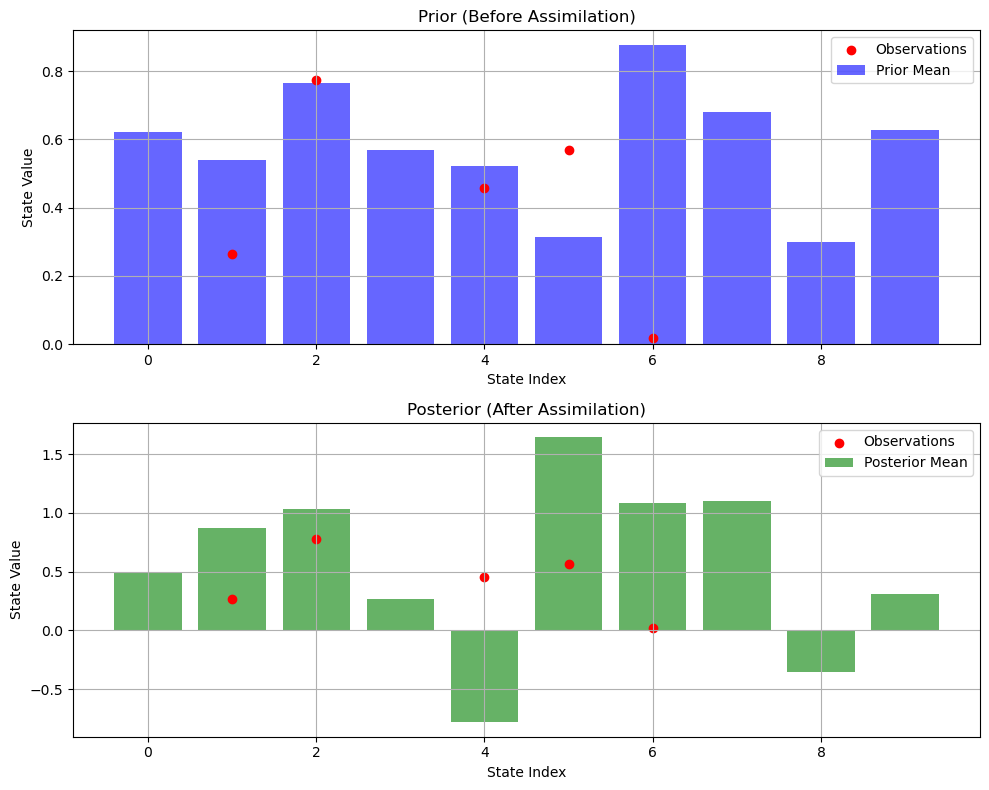

In [204]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the prior (before assimilation)
axs[0].bar(np.arange(n_states), data_f.mean(axis=1), color='b', alpha=0.6, label='Prior Mean')
axs[0].scatter(obs_index, obs_values, color='r', label='Observations')
axs[0].set_title('Prior (Before Assimilation)')
axs[0].set_xlabel('State Index')
axs[0].set_ylabel('State Value')
axs[0].legend()
axs[0].grid(True)

# Plot the posterior (after assimilation)
axs[1].bar(np.arange(n_states), data_a.mean(axis=1), color='g', alpha=0.6, label='Posterior Mean')
axs[1].scatter(obs_index, obs_values, color='r', label='Observations')
axs[1].set_title('Posterior (After Assimilation)')
axs[1].set_xlabel('State Index')
axs[1].set_ylabel('State Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [228]:
import functions  
importlib.reload(functions)
from functions import enkf_update

dim_vals = n_states
dim_obs = n_obs
obs_index = [1, 2, 4, 5, 6]
obs_var = obs_stdev * obs_stdev
obs_ens = Dobs_mat

data_f = pd.DataFrame(forecast_ensemble)
data_a = enkf_update(data_f, n_ensemble, dim_vals, obs_ens, dim_obs, obs_var, obs_index, visualize=False, outname="output")

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[-5.05521171e-02  2.24923359e-01  1.41279002e-01 -8.09661179e-04
   4.91837721e-02]
 [ 5.01640655e-02 -1.02017398e-01 -1.66866356e-01  9.32087593e-02
  -1.16963655e-02]
 [-1.02017398e-01  7.81035438e-01  2.13108947e-01  2.47815710e-01
   1.99434662e-01]
 [-1.22813279e-01  5.57717151e-01  3.40746037e-01  6.63423162e-03
   1.22943221e-01]
 [-1.66866356e-01  2.13108947e-01  5.82852624e-01 -4.06317288e-01
   2.46409470e-04]
 [ 9.32087593e-02  2.47815710e-01 -4.06317288e-01  5.06707094e-01
   1.12207621e-01]
 [-1.16963655e-02  1.99434662e-01  2.46409470e-04  1.12207621e-01
   5.65174417e-02]
 [ 1.11233362e-01 -4.16442079e-01 -3.28138056e-01  6.16207657e-02
  -8.41911440e-02]
 [-1.72184680e-01  6.41688095e-01  5.08592920e-01 -9.76337686e-02
   1.29421902e-01]
 [ 9.11476935e-02 -7.44850823e-01 -1.80050686e-01 -2.57276404e-01
  -

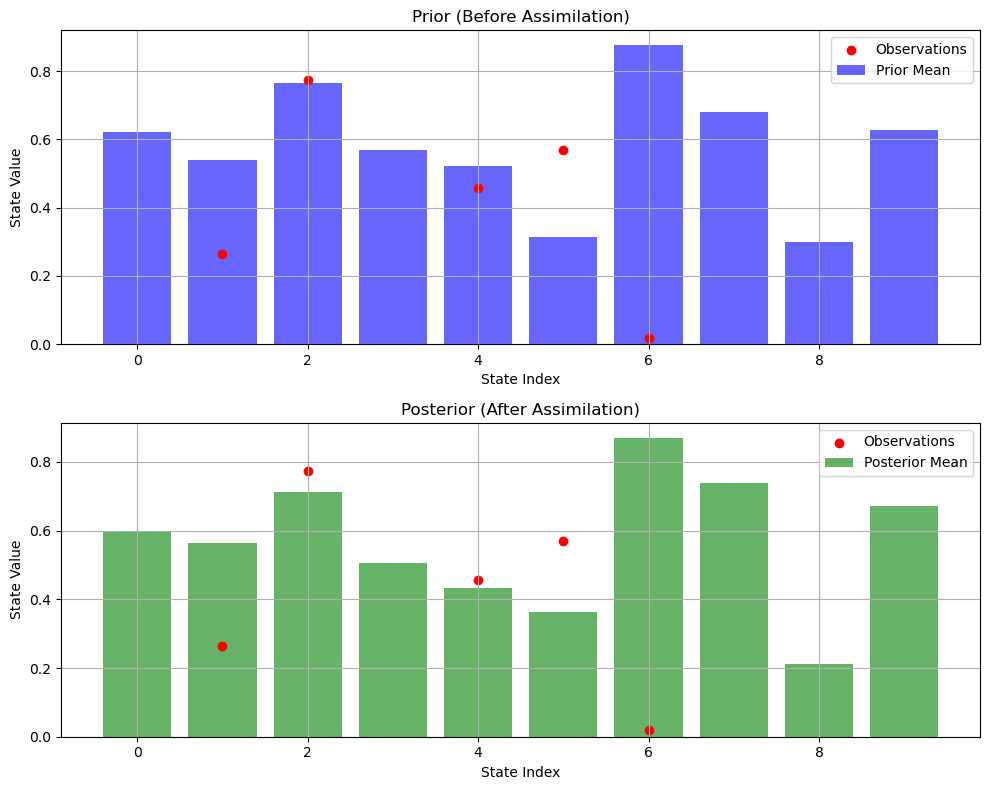

In [229]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the prior (before assimilation)
axs[0].bar(np.arange(n_states), data_f.mean(axis=1), color='b', alpha=0.6, label='Prior Mean')
axs[0].scatter(obs_index, obs_values, color='r', label='Observations')
axs[0].set_title('Prior (Before Assimilation)')
axs[0].set_xlabel('State Index')
axs[0].set_ylabel('State Value')
axs[0].legend()
axs[0].grid(True)

# Plot the posterior (after assimilation)
axs[1].bar(np.arange(n_states), data_a.mean(axis=1), color='g', alpha=0.6, label='Posterior Mean')
axs[1].scatter(obs_index, obs_values, color='r', label='Observations')
axs[1].set_title('Posterior (After Assimilation)')
axs[1].set_xlabel('State Index')
axs[1].set_ylabel('State Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

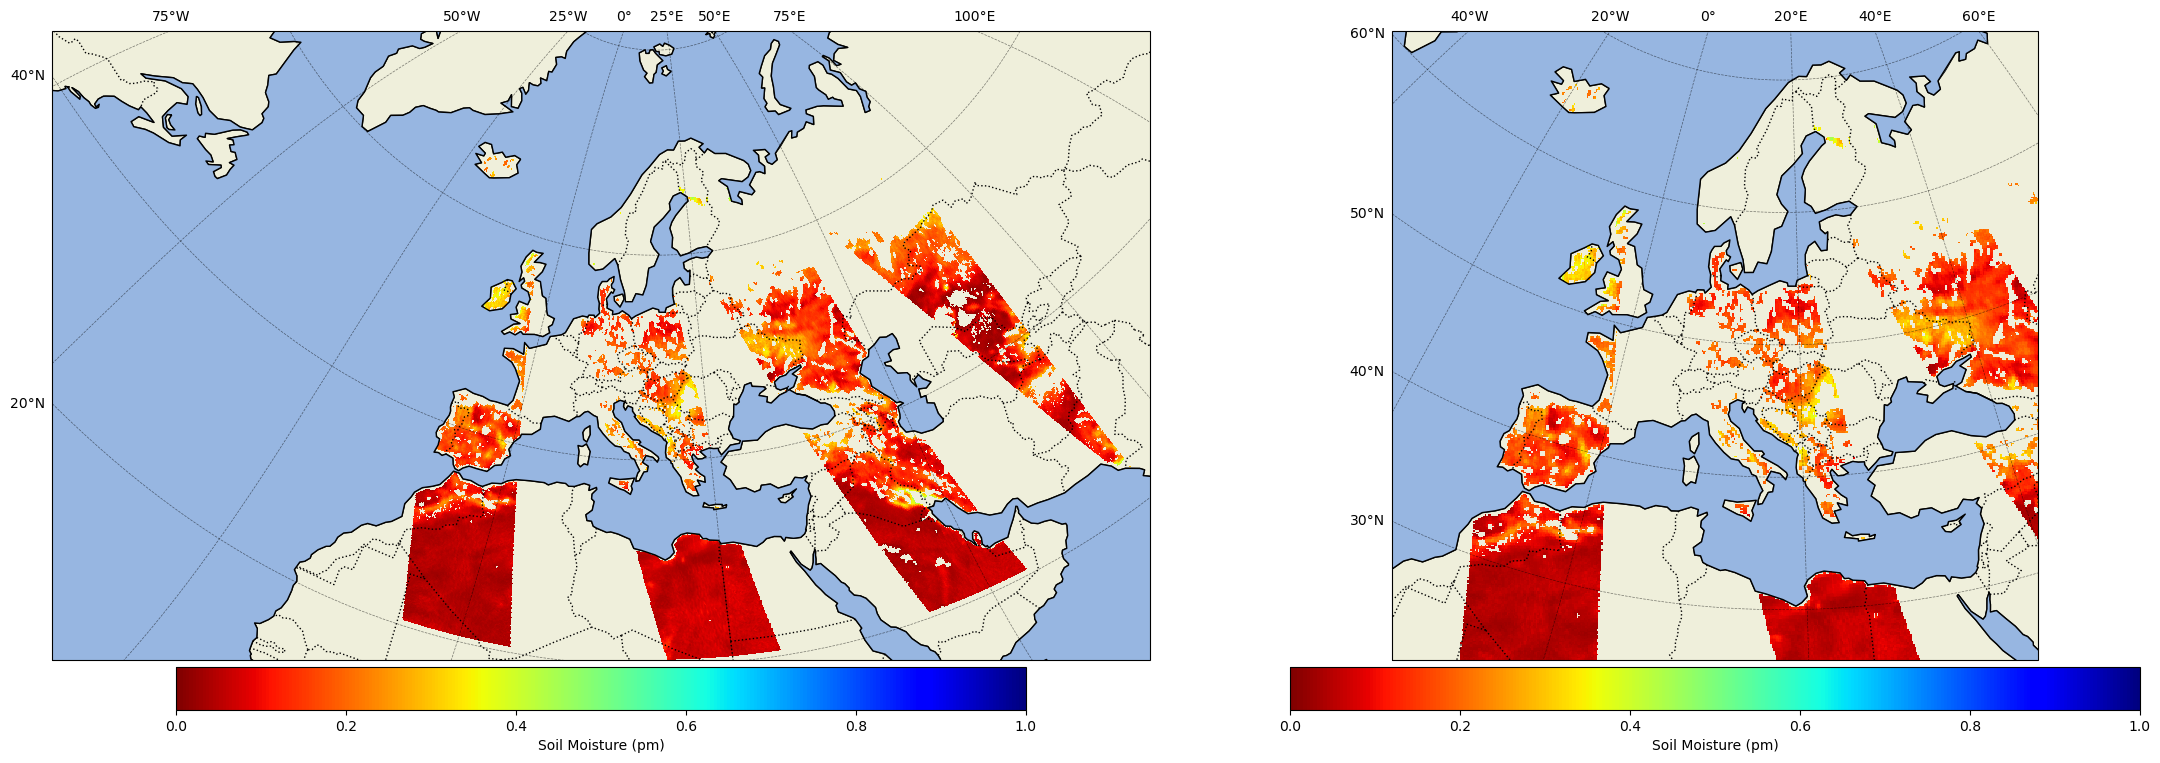

In [9]:
from scipy.interpolate import griddata
lat_min = lats.min().item()
lat_max = lats.max().item()
lon_min = lons.min().item()
lon_max = lons.max().item()

file_name = '/p/scratch/cjibg36/jibg3674/SMAP_EURO/NSIDC0772_LatLon_EASE2_M09km_v1.0.nc'
nc_file = netCDF4.Dataset(file_name, 'r')
lon_ease   = nc_file.variables['longitude'][:]
lat_ease   = nc_file.variables['latitude'][:]

lat_mask = (lat_ease >= lat_min) & (lat_ease <= lat_max)
lon_mask = (lon_ease >= lon_min) & (lon_ease <= lon_max)
latlon_mask = lat_mask & lon_mask
lat_indices = np.where((lat_ease[:, 0] >= lat_min) & (lat_ease[:, 0] <= lat_max))[0]
lon_indices = np.where((lon_ease[0, :] >= lon_min) & (lon_ease[0, :] <= lon_max))[0]
lat_subset_2d = lat_ease[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
lon_subset_2d = lon_ease[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

nc_file.close()

ease_points = np.array([lat_subset_2d.flatten(), lon_subset_2d.flatten()]).T
smap_points = a.values.flatten()

grid_points = np.array([lats.flatten(), lons.flatten()]).T
sm_interp = griddata(ease_points, smap_points, grid_points, method='nearest')
sm_interp = sm_interp.reshape(lats.shape)

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import pandas as pd 
from datetime import datetime
%matplotlib inline
proj = ccrs.RotatedPole(pole_longitude=-162.0, pole_latitude=39.25, central_rotated_longitude=0, globe=None)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8), subplot_kw={'projection': proj})

# Plot the original SMAP data
ax[0].add_feature(cfeature.COASTLINE)
ax[0].add_feature(cfeature.BORDERS, linestyle=':')
ax[0].add_feature(cfeature.LAND, edgecolor='black')
ax[0].add_feature(cfeature.OCEAN)

cmap = plt.get_cmap('jet_r').copy()
cmap.set_extremes(under='k', over='r')

c1 = ax[0].pcolormesh(
    lon_subset_2d,
    lat_subset_2d,
    a.values,
    cmap=cmap,
    shading='auto',
    vmin=0,  # Adjust as necessary for soil moisture range
    vmax=1,  # Adjust as necessary for soil moisture range
    transform=ccrs.PlateCarree())
# Add a colorbar for the first subplot
cbar1 = plt.colorbar(c1, ax=ax[0], orientation='horizontal', pad=0.01, shrink=0.7)
cbar1.set_label('Soil Moisture (pm)')

gl1 = ax[0].gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', y_inline=False, x_inline=False, draw_labels=True)
gl1.right_labels = False
gl1.bottom_labels = False

# Plot the regridded SMAP data
ax[1].add_feature(cfeature.COASTLINE)
ax[1].add_feature(cfeature.BORDERS, linestyle=':')
ax[1].add_feature(cfeature.LAND, edgecolor='black')
ax[1].add_feature(cfeature.OCEAN)

c2 = ax[1].pcolormesh(
    lons,
    lats,
    sm_interp,
    cmap=cmap,
    shading='auto',
    vmin=0,  # Adjust as necessary for soil moisture range
    vmax=1,  # Adjust as necessary for soil moisture range
    transform=ccrs.PlateCarree())

# Add a colorbar for the second subplot
cbar2 = plt.colorbar(c2, ax=ax[1], orientation='horizontal', pad=0.01, shrink=0.7)
cbar2.set_label('Soil Moisture (pm)')

gl2 = ax[1].gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', y_inline=False, x_inline=False, draw_labels=True)
gl2.right_labels = False
gl2.bottom_labels = False

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
date_results_iter

[[Timestamp('2019-01-31 20:00:00'), Timestamp('2019-05-01 20:00:00')],
 [Timestamp('2019-05-01 20:00:00', freq='3D'),
  Timestamp('2019-05-04 20:00:00', freq='3D'),
  Timestamp('2019-05-07 20:00:00', freq='3D'),
  Timestamp('2019-05-10 20:00:00', freq='3D'),
  Timestamp('2019-05-13 20:00:00', freq='3D'),
  Timestamp('2019-05-16 20:00:00', freq='3D'),
  Timestamp('2019-05-19 20:00:00', freq='3D'),
  Timestamp('2019-05-22 20:00:00', freq='3D'),
  Timestamp('2019-05-25 20:00:00', freq='3D'),
  Timestamp('2019-05-28 20:00:00', freq='3D'),
  Timestamp('2019-05-31 20:00:00', freq='3D'),
  Timestamp('2019-06-03 20:00:00', freq='3D'),
  Timestamp('2019-06-06 20:00:00', freq='3D'),
  Timestamp('2019-06-09 20:00:00', freq='3D'),
  Timestamp('2019-06-12 20:00:00', freq='3D'),
  Timestamp('2019-06-15 20:00:00', freq='3D'),
  Timestamp('2019-06-18 20:00:00', freq='3D'),
  Timestamp('2019-06-21 20:00:00', freq='3D'),
  Timestamp('2019-06-24 20:00:00', freq='3D'),
  Timestamp('2019-06-27 20:00:00', f

In [20]:
import numpy as np
import os
import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
import netCDF4
from scipy.interpolate import griddata


def get_TSMP_grid(file_centre,file_corner,ignore_rivers=False):
    grid_centre = xr.open_dataset(file_centre, decode_times=False)
    grid_corner = xr.open_dataset(file_corner)

    lon_edges = np.concatenate((grid_corner.lon.values[:,-1],grid_corner.lon.values[:,0],grid_corner.lon.values[0,:],grid_corner.lon.values[-1,:]))
    lat_edges = np.concatenate((grid_corner.lat.values[:,-1],grid_corner.lat.values[:,0],grid_corner.lat.values[0,:],grid_corner.lat.values[-1,:]))
    lsm_edges = np.zeros(lat_edges.shape)
    
    grid_TSMP = xr.Dataset(data_vars=dict(lon_centre=(['x','y'], grid_centre.lon.values),
                                          lat_centre=(['x','y'], grid_centre.lat.values),
                                          lon_corner=(['xc','yc'], grid_corner.lon.values),
                                          lat_corner=(['xc','yc'], grid_corner.lat.values),
                                          lsm=(['x','y'], grid_centre.LLSM[0].values),
                                          lon_edges=(['ne'], lon_edges),
                                          lat_edges=(['ne'], lat_edges),
                                          lsm_edges=(['ne'], lsm_edges)))
    
    
    if ignore_rivers:
        # in the land-sea mask, set rivers to a value of 3, in which case they are ignored later in the interpolation process
        grid_TSMP['lsm'] = grid_TSMP['lsm'].where((grid_centre.mask_rivers.values==0),3)

    return grid_TSMP

def get_TSMP_coords(file_centre):
    grid_centre = xr.open_dataset(file_centre, decode_times=False)
    grid_TSMP = xr.Dataset(data_vars=dict(lon_centre=(['x','y'], grid_centre.lon.values),
                                          lat_centre=(['x','y'], grid_centre.lat.values),
                                          lsm=(['x','y'], grid_centre.LLSM[0].values)))
    return grid_TSMP

def parse_datetime_smap(files):
    dates = []
    for file_ in files:
        date_ = pd.to_datetime(os.path.basename(file_).split('P_E_')[1].split('_')[0]) + timedelta(hours=12)
        dates.append(date_)
    return dates

def read_SMAP(file_):
    ncf = netCDF4.Dataset(file_)
    group_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')
    group_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')

    data_pm = xr.open_dataset(xr.backends.NetCDF4DataStore(group_pm))
    data_am = xr.open_dataset(xr.backends.NetCDF4DataStore(group_am))

    return data_am, data_pm

def unpackbits(x, num_bits):
    #function that converts int into series of bits (used for 0/1 in SMAP quality flags)
    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")
    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])
    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])

class operator_clm_SMAP:
    
    def __init__(self,file_lsm,file_corner,folder_SMAP,ignore_rivers=False):
   
        # 1) get TSMP grid: is used to select SMAP results falling withing this domain. A corner file is required to discard points outside of the domain       
        self.grid_TSMP = get_TSMP_grid(file_lsm,file_corner,ignore_rivers=ignore_rivers)   
        self.folder_SMAP = folder_SMAP
        
    def flatten_y(self,y_in):
        # flatten dict with values into a np.array
        y_out = np.array([])
        for val in y_in.values():
            y_out = np.append(y_out,val)        
        return y_out

    def get_measurements(self,date_results_iter,date_DA_start=datetime(1900,1,1),date_DA_end=datetime(2200,1,1),
                         mode='pm',qual_level=1,return_latlon=None,return_date=False,max_deviation_time=timedelta(days=1)):
        self.lons_out = {}
        self.lats_out = {}
        self.sm_out = {}
        array_dates = np.array([])
        
        for date_results in [date_results_iter]:
            
            for date_ in [date_results]:

                if date_ < date_DA_start or date_ > date_DA_end:
                    print('Skipping %s: outside of range %s-%s'%(str(date_),str(date_DA_start),str(date_DA_end)) )
                else:
                    # 2) get all available SMAP dates
                    files_SMAP = sorted(glob(os.path.join(self.folder_SMAP,'nc_%4.4i/*.nc'%date_.year)))
                    dates_SMAP = parse_datetime_smap(files_SMAP)

                    # 3) for the given model date (date_) get the corresponding SMAP data
                    i_closest = np.argmin(np.abs(pd.to_datetime(dates_SMAP) - date_))
                    diff_days = abs(dates_SMAP[i_closest] - date_)
                    if diff_days > max_deviation_time:
                        print('Measurement and model output differ more than a day, SMAP: %s, TSMP: %s'%(dates_SMAP[i_closest],date_))
                        # This happens e.g. when not every day has a measurement
                    else:
                        file_SMAP = files_SMAP[i_closest]
                        data_SMAP_am, data_SMAP_pm = read_SMAP(file_SMAP)
                        print(date_,file_SMAP)

                        if mode == 'am':
                            # 4) select valid datapoints where the soil moisture and location are given
                            mask_data_valid = ~np.isnan(data_SMAP_am.soil_moisture) & ~np.isnan(data_SMAP_am.longitude) 
                            if qual_level > 0: #quality level; when 0 use all retrievals, with 1 only use recommended retrievals
                                qual_flags = unpackbits(data_SMAP_am.retrieval_qual_flag.values.astype(int),4)
                                mask_data_valid = mask_data_valid & (qual_flags[:,:,0]==0)
                            # 5) Select valid points: valid data, and within the given TSMP domain
                            sm = data_SMAP_am.soil_moisture.where(mask_data_valid).values[mask_data_valid]
                            lons = data_SMAP_am.longitude.where(mask_data_valid).values[mask_data_valid]
                            lats = data_SMAP_am.latitude.where(mask_data_valid).values[mask_data_valid]
                        elif mode == 'pm':
                            mask_data_valid = ~np.isnan(data_SMAP_pm.soil_moisture_pm) & ~np.isnan(data_SMAP_pm.longitude_pm) 
                            if qual_level > 0: #quality level; when 0 use all retrievals, with 1 only use recommended retrievals
                                qual_flags = unpackbits(data_SMAP_pm.retrieval_qual_flag_pm.values.astype(int),4)
                                mask_data_valid = mask_data_valid & (qual_flags[:,:,0]==0)
                            # 5) Select valid points: valid data, and within the given TSMP domain
                            sm = data_SMAP_pm.soil_moisture_pm.where(mask_data_valid).values[mask_data_valid]
                            lons = data_SMAP_pm.longitude_pm.where(mask_data_valid).values[mask_data_valid]
                            lats = data_SMAP_pm.latitude_pm.where(mask_data_valid).values[mask_data_valid]
                            print(f"data_SMAP_pm.soil_moisture_pm [{date_}] is: {data_SMAP_pm.soil_moisture_pm.shape}")
                            print(f"The shape of sm[{date_}] is: {sm.shape}")

                        else:
                            raise RuntimeError('mode should be am or pm')

                        # poor man's check that measurement points are on land and lie within the TSMP domain... There might be a better solution for this (convex hull check on EU-11 polygon?) 
                        mask_SMAP_lsm = griddata((np.concatenate((self.grid_TSMP.lon_centre.values.ravel(),self.grid_TSMP.lon_edges)),np.concatenate((self.grid_TSMP.lat_centre.values.ravel(),self.grid_TSMP.lat_edges))),
                                                 np.concatenate((self.grid_TSMP.lsm.values.ravel(),self.grid_TSMP.lsm_edges)),
                                                 (lons,lats),method='nearest') == 2

                        self.lons_out[date_] = lons[mask_SMAP_lsm]
                        self.lats_out[date_] = lats[mask_SMAP_lsm]
                        self.sm_out[date_] = sm[mask_SMAP_lsm]
                        print(f"The shape of sm_out[{date_}] is: {self.sm_out[date_].shape}")
                        array_dates = np.append(array_dates, np.array([date_ for i in range(mask_SMAP_lsm.sum())]))
        if return_latlon and not return_date:
            return self.flatten_y(self.sm_out), None, np.array([self.flatten_y(self.lats_out), self.flatten_y(self.lons_out)]).T
        elif return_latlon and return_date:
            return self.flatten_y(self.sm_out), None, np.array([self.flatten_y(self.lats_out), self.flatten_y(self.lons_out)]).T, array_dates
        else:
            return self.flatten_y(self.sm_out), None #return measured values and their uncertainties if available
        
    def interpolate_model_results(self,i_real,settings_run,indices_z=[0,1],var='SOILLIQ',history_stream='h0'):
        self.data_TSMP_i = {}
        self.files_clm = {}
        files_clm = sorted(glob(os.path.join(settings_run['dir_iter'],'R%3.3i/**/*.clm2.%s.*.nc'%(i_real,history_stream) )))
        # assert len(files_clm) == len(self.sm_out.keys()), 'Something might have gone wrong in realization %i: not every date has a matching file'%i_real

        for i1,date_ in enumerate(self.sm_out.keys()):
            date_find = str(date_.date())
            file_matching = [s for s in files_clm if date_find in s]
            
            if len(file_matching) > 1:
                print('%i matching files found (%s), taking the last file' %(len(file_matching),sorted(file_matching)))
                file_clm = sorted(file_matching)[-1]
            elif len(file_matching) == 1:
                file_clm = file_matching[0]
            else:
                file_clm = None
                raise RuntimeError('This operator only works for (more than) one matching model file per date, date:%s, i_real: %i, files: %s'%(date_find,i_real,file_matching) )
            
            self.files_clm[date_] = file_clm
            
            # file_clm = sorted(glob(os.path.join(settings_run['dir_iter'],'R%3.3i/**/clm.clm2.h0.*.nc'%i_real)))[i1]
            # print(date_,file_clm)
            
            data_TSMP = xr.open_dataset(file_clm)
            # add curvilinear lon/lat 
            data_TSMP = data_TSMP.assign_coords(lon_c=(('lat','lon'), self.grid_TSMP.lon_centre.values))
            data_TSMP = data_TSMP.assign_coords(lat_c=(('lat','lon'), self.grid_TSMP.lat_centre.values))

            # self.data_TSMP = data_TSMP
            if var == 'H2OSOI':
                SM = data_TSMP.H2OSOI[0]
            elif var == 'SOILLIQ': #base moisture on liquid part only
                eCLM_dz = np.array([0.02,0.04,0.06,0.08,0.120,
                                    0.160,0.200,0.240,0.280,0.320,
                                    0.360,0.400,0.440,0.540,0.640,
                                    0.740,0.840,0.940,1.040,1.140,
                                    2.390,4.676,7.635,11.140,15.115])
                SM = data_TSMP.SOILLIQ[0]/(eCLM_dz[0:20,np.newaxis,np.newaxis]*1000)
            else:
                raise RuntimeError('For soil moisture only H2OSOI and SOILLIQ supported')
                            
            
            if indices_z is None:
                data_TSMP_sm = SM[0].values
            elif type(indices_z) == int:
                data_TSMP_sm = SM[indices_z].values
            elif type(indices_z) == list:
                indices_select = np.ix_(np.array(indices_z),
                                        np.arange(SM.values.shape[1]),
                                        np.arange(SM.values.shape[2]))
                data_TSMP_sm = SM.values[indices_select].mean(axis=0)
            else:
                raise RuntimeError('indices_z should be None, int, or list of ints')
                
            mask_nan = ~np.isnan(data_TSMP_sm)
            
            self.data_TSMP_i[date_] = griddata((data_TSMP.lon_c.values[mask_nan],data_TSMP.lat_c.values[mask_nan]),data_TSMP_sm[mask_nan],(self.lons_out[date_],self.lats_out[date_]), method='nearest')

        # save most likely parameter output for plotting
        if i_real == 0:
            self.data_TSMP_ml = self.data_TSMP_i.copy()
            
        return self.flatten_y(self.data_TSMP_i)
    

In [21]:
operator = {}
data_measured = {}
data_latlon = {}

# Operator for SMAP
operator['SMAP'] = operator_clm_SMAP(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_SMAP'],ignore_rivers=False)
data_measured['SMAP'],_,data_latlon['SMAP'] = operator['SMAP'].get_measurements(date_results_iter[1][0],date_DA_start=date_results_iter[1][0],return_latlon=True)

2019-05-01 20:00:00 /p/project/cjibg36/jibg3674/shared_DA/SMAP/nc_2019/SMAP_L3_SM_P_E_20190501_R18290_001_HEGOUT.nc
data_SMAP_pm.soil_moisture_pm [2019-05-01 20:00:00] is: (538, 1286)
The shape of sm[2019-05-01 20:00:00] is: (116841,)
The shape of sm_out[2019-05-01 20:00:00] is: (50514,)


In [17]:
data_measured['SMAP'].shape

(50514,)

In [ ]:
data_var = copy.deepcopy(settings_DA['data_var']) #data_var is changed in the code; make therefore deepcopy
data_mask = {'SMAP':None, #initialize dict
            'FLX':None}

In [51]:
import matplotlib.pyplot as plt

ensemble_size = 4
ensemble_members = [np.random.rand(410, 412) for _ in range(ensemble_size)]
len(ensemble_members)

4

In [22]:
import netCDF4 as nc
import numpy as np

# Open the NetCDF file
file_path = '/p/project/cjibg36/jibg3674/shared_DA/EUR-11_TSMP_FZJ-IBG3_444x432_LAND-LAKE-SEA-MASK.nc'
dataset = nc.Dataset(file_path, 'r')

# Replace 'variable_name' with the actual name of the variable you want to read
var = 'LLSM'  # Update with the correct variable name
read_var = dataset.variables[var][:] # (1, 432, 444) 432*444 = 191808

count1 = np.count_nonzero(read_var == 2)
count2 = np.count_nonzero(read_var != 0)

# Print the result
print(f'Number of values equal to 2: {count1}')
print(f'Number of values not equal to 0: {count2}')
# Close the dataset
dataset.close()

Number of values equal to 2: 103152
Number of values not equal to 0: 103833


In [23]:
import numpy as np

# Original 2D array (410 * 412)
data_2d = np.random.rand(410, 412)  # Example data

# Example sea mask (True for land, False for sea)
sea_mask = np.random.choice([True, False], size=(410, 412))

# Flatten to 1D by applying the sea mask
data_1d = data_2d[sea_mask]

# Example data assimilation (here, we'll just add 1 to the data as a placeholder)
data_assimilated_1d = data_1d + 1  # Perform your actual data assimilation here

# Reconstruct the 2D array
data_reconstructed_2d = np.full(data_2d.shape, np.nan)
data_reconstructed_2d[sea_mask] = data_assimilated_1d

# Now `data_reconstructed_2d` has the same shape as the original, with the assimilated values in the correct positions
print(data_reconstructed_2d.shape)

(410, 412)
